# Final Model: Feature Dedicated Ensemble

This notebook aggregates the results of the team's findings on pixel and patch feature reduction and model design and implementation.

# Loading the data


In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [10]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')

Remove all datapoints (images) that have a quality of 1 or less. Quality of 1 or less corresponds to a poor image.

In [11]:
train = train[train.Quality > 1]

Loading image_arrays_train/MH2O0YH.npy as an array
(360, 41, 41)
(41, 41)


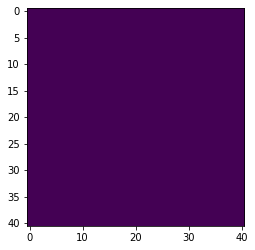

In [12]:
# Look at a sample:
# get a random sample from the dataset
#fid = train['Field_ID'].sample().values[0]
fid = train['Field_ID'].values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')

# load the randomly sampled datapoint image
arr = np.load(fn) # Loading the data with numpy
print(arr.shape)
#print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
#rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = arr[359]
print(rgb_jan.shape)
max_val = np.max(rgb_jan) 
if max_val == 0:
    max_val = 1
rgb_jan = rgb_jan / max_val # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

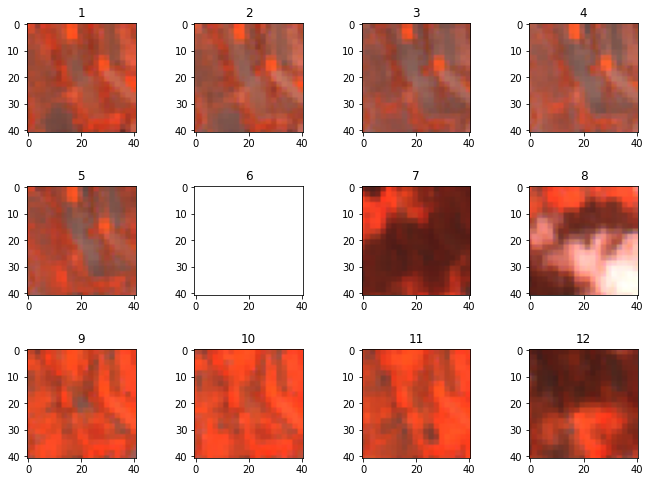

In [13]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

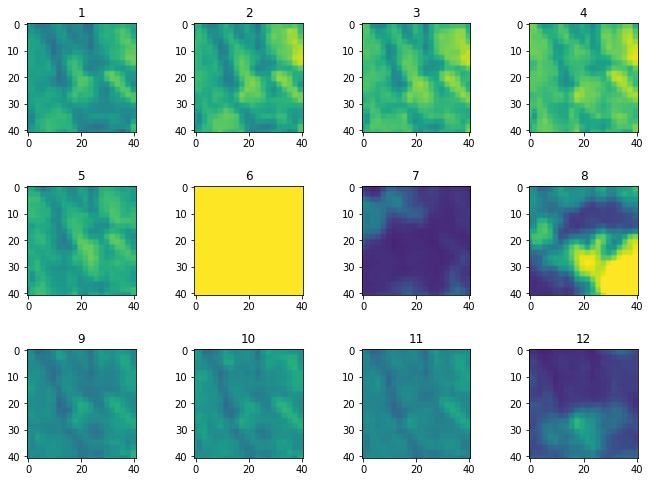

In [14]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

In [15]:
# look at all the images for a single field.

fid = train['Field_ID'].values[300]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')

# load the randomly sampled datapoint image
arr = np.load(fn) # Loading the data with numpy
"""
for j in range(30):
    fig, axs = plt.subplots(2, 6, figsize=(18, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(12):
      image = arr[i*30 + j]
      axs[i].imshow(image)
      axs[i].set_title(str(i+1))
"""

Loading image_arrays_train/FT3VG8R.npy as an array


"\nfor j in range(30):\n    fig, axs = plt.subplots(2, 6, figsize=(18, 6), facecolor='w', edgecolor='k')\n    fig.subplots_adjust(hspace = .5, wspace=.001)\n    axs = axs.ravel()\n    for i in range(12):\n      image = arr[i*30 + j]\n      axs[i].imshow(image)\n      axs[i].set_title(str(i+1))\n"

It is immediately evident from viewing the data that bands 14 - 30 do not seem to contain useful data. The data in images from these bands are constant data. We will automate a test to see if this is true. 

In [16]:
good_bands = []
good_images = []
for fid in train['Field_ID'].values:
    fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
    arr = np.load(fn) # Loading the data with numpy
    for j in range(13,30):
        for i in range(12):
            max = np.amax(arr[i*30 + j])
            min = np.min(arr[i*30 + j])
            if min != max:
                if j not in good_bands:
                    good_bands.append(j)
                good_images.append("FID: {}, band: {}, month: {}".format(fid, j, i))
print("Number of good bands in bands 13-30: {}".format(len(good_bands))) 
print("Bands: {}".format(good_bands))

Number of good bands in bands 13-30: 14
Bands: [15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]


It looks as though there are some good images in those bands. The bad bands that offer no data across the entire dataset are bands 13, 14, and 24. These will be excluded from any analysis or feature selection. 

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [17]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]

There are a couple ways to train. One way is to consider each image as an example, so that features of the examples are pixels. Each field ID has 360 images: 30 bands, with 12 images per band, corresponding to each month. Reduce features on this training model to find which pixels are most useful. Then once the most useful pixels are determined, change the dataset. Now, examples will be field IDs, where features are different bands in that field ID. The value of each feature will be a pixel value for that band. It is possible to have multiple pixels for a single band, all as different features for that example. 

Here is the training model to determine patch worth. Each example is an patch of pixels within an image, with pixels as features. It is tested with one field ID at a time. The y value for an example image is the yield for the field ID that the image belongs to. This can be a useful tool in finding which patches of the images are good for focusing on.

In [18]:
def get_image(fid, b, m, w):
    fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
    # load the randomly sampled datapoint image
    arr = np.load(fn) # Loading the data with numpy
    window = []
    for i in w[0]:
        for j in w[1]:
            window.append(arr[m*30 + b][i][j])
    return window


idxs = np.random.choice(range(train.shape[0]), size=200, replace=False)

dfs = []

w = [range(0,10), range(0,10)]
"""
for j in idxs:
    # make a dataframe for the first field id
    df = pd.concat([pd.DataFrame([get_image(train['Field_ID'].values[j], b, m, w)]) 
                    for b in range(30) for m in range(12)], ignore_index=True)
    field_id = []
    yield_vals = []
    months = []
    bands = []
    for i in range(12*30):
        field_id.append(train['Field_ID'].values[j])
        yield_vals.append(train['Yield'].values[j])
    for m in range(12):
        for b in range(30):
            months.append(m)
            bands.append(b)
    df['Month'] = months
    df['Band'] = bands
    df['Field_ID'] = field_id 
    df['Yield'] = yield_vals
    dfs.append(df)

# combine the dataframes in dfs into a single df
df = pd.concat(dfs, ignore_index=True)
# shuffle the rows so that they're randomized
df.sample(frac=1)
"""

"\nfor j in idxs:\n    # make a dataframe for the first field id\n    df = pd.concat([pd.DataFrame([get_image(train['Field_ID'].values[j], b, m, w)]) \n                    for b in range(30) for m in range(12)], ignore_index=True)\n    field_id = []\n    yield_vals = []\n    months = []\n    bands = []\n    for i in range(12*30):\n        field_id.append(train['Field_ID'].values[j])\n        yield_vals.append(train['Yield'].values[j])\n    for m in range(12):\n        for b in range(30):\n            months.append(m)\n            bands.append(b)\n    df['Month'] = months\n    df['Band'] = bands\n    df['Field_ID'] = field_id \n    df['Yield'] = yield_vals\n    dfs.append(df)\n\n# combine the dataframes in dfs into a single df\ndf = pd.concat(dfs, ignore_index=True)\n# shuffle the rows so that they're randomized\ndf.sample(frac=1)\n"

The above method proved to be intolerably slow, even for a small sample size of 200 fields (although this is 200 * 360 images, each of which must be reduced to the desired window. This method will not work for patch analysis. Time to think of a new method.

# Pixel and Patch Reduction


0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

Below is a function that will sample a desired pixel value for the specified months. It samples from all of the useful bands, where usefulness is determined above. 

In [19]:
def sample_pixel(fid, pixel_a, pixel_b, month_range, folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn)
    bands = ['S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 
             'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'S2_B9', 
             'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA10', 'S2_QA20', 
             'S2_QA60', 'CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 
             'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 
             'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']
    # exclude bands 13, 14, and 24
    band_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16 , 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]
    bands_of_interest = [bands[x] for x in band_idxs]
    values = {}
    for month in range(month_range[0], month_range[1]):
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        # get the whole image in the form of an array
        vs = np.empty(idxs[0].size)
        i=0
        for idx in idxs[0]:          
            vs[i] = arr[idx, pixel_a, pixel_b]
            i+=1
        #vs = arr[idxs, 20, 20]
        for bn, v in zip(bns, vs):
            values[bn] = v
    return values

# # Example
# process_im('35AFSDD', 20, 20)

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features: Here is an example dataframe with the pixel (20,20). 

In [21]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([sample_pixel(fid, 20, 20, range(0,11)) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B1,0_S2_B2,0_S2_B3,0_S2_B4,0_S2_B5,0_S2_B6,0_S2_B7,0_S2_B8,0_S2_B8A,0_S2_B9,...,0_CLIM_ro,0_CLIM_soil,0_CLIM_srad,0_CLIM_tmmn,0_CLIM_tmmx,0_CLIM_vap,0_CLIM_vpd,0_CLIM_vs,Field_ID,Yield
0,1024.0,934.0,932.0,1173.0,1392.0,1798.0,2044.0,2038.0,2327.0,1072.0,...,0.0,287.0,2543.0,112.0,285.0,1246.0,138.0,260.0,MH2O0YH,3.686
1,1023.0,880.0,821.0,924.0,1116.0,1630.0,1870.0,1951.0,2040.0,929.0,...,0.0,287.0,2581.0,108.0,288.0,1260.0,138.0,220.0,O9TURWL,5.657
2,1095.0,1016.0,1070.0,1357.0,1632.0,1972.0,2256.0,2137.0,2588.0,957.0,...,0.0,278.0,2571.0,109.0,288.0,1276.0,137.0,240.0,35AFSDD,3.082
3,976.0,777.0,784.0,639.0,1064.0,2014.0,2561.0,2588.0,2921.0,1300.0,...,0.0,299.0,2550.0,110.0,282.0,1236.0,134.0,250.0,PM05EG9,2.707
4,1300.0,1081.0,1122.0,1162.0,1487.0,2336.0,2698.0,2603.0,2984.0,710.0,...,1.0,427.0,2438.0,161.0,320.0,1575.0,173.0,270.0,V7PZBCG,2.679


Rather than sampling a single pixel, we can sample a patch by taking the average pixel value over that patch. 

In [37]:
def sample_patch(fid, pixel_a, pixel_b, N, month_range, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands = ['S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'S2_B9', 'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA10', 'S2_QA20', 'S2_QA60', 'CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']
  band_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16 , 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]
  bands_of_interest = [bands[x] for x in band_idxs]
  values = {}
  for month in range(month_range[0], month_range[1]):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    # get the whole image in the form of an array
    vs = np.empty(idxs[0].size)
    i=0
    for idx in idxs[0]:    
        # take the average value over the patch of width N
        vs[i] = np.mean(arr[idx, pixel_a:pixel_a+N, pixel_b:pixel_b+N])
        i+=1
    for bn, v in zip(bns, vs):
        values[bn] = v
  return values

Now we search for a new model to assess patch value. The following method is slow, but works better than the previous model and seems to give intuitive results. A simple regressor, linear regressor, is trained on each pixel in each patch. Then the whole patch is assessed based on the average error of the regressors for each pixel and the variance of errors is assessed to see if the patch is quite uniform or if it needs to be broken up into smaller patches. This is a good way of eliminating large portions of the image. **If the .csv files for this data exist already, do not run the next cell.**

In [38]:
def make_df(data, pixel_a, pixel_b, idxs, month_range=(0,12)):
    # sample the pixels from train
    train_sampled = pd.DataFrame([sample_pixel(fid, pixel_a, pixel_b, month_range) 
                                  for fid in data['Field_ID'].values[idxs]])
    # Add in the field ID and yield
    train_sampled['Field_ID'] = data['Field_ID'].values[idxs]
    train_sampled['Yield'] = data['Yield'].values[idxs]
    return train_sampled

def make_df_patch(data, pixel_a, pixel_b, size, idxs, month_range=(0,12)):
    # sample the pixels in the patch from train
    train_sampled = pd.DataFrame([sample_patch(fid, pixel_a, pixel_b, size, month_range) 
                                  for fid in data['Field_ID'].values[idxs]])
    # Add in the field ID and yield
    train_sampled['Field_ID'] = data['Field_ID'].values[idxs]
    train_sampled['Yield'] = data['Yield'].values[idxs]
    return train_sampled

def split_train(data):
    # Split the data  
    fractions = [0.9, 1.0, 0.0]
    data_train = data[0:int(np.floor(data.shape[0]*fractions[0]))]
    data_val = data[int(np.floor(data.shape[0]*fractions[0])):int(np.floor(data.shape[0]*fractions[1]))]
    data_test = data[int(np.floor(data.shape[0]*fractions[1])):]
    return (data_train, data_val, data_test)

def split_xy(train_sampled):
    # Split the data
    X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']   
    return (X, y)

def split(train_sampled):
    data_train, data_val, data_test = split_train(train_sampled)
    X_train, y_train = split_xy(data_train)
    X_val, y_val = split_xy(data_val)
    X_test, y_test = split_xy(data_test)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

Below is the routine that trains a Linear Regressor on each pixel or on each patch. This cell is quite time consuming and the results have already been stored in their respective csv files. There is no need to run these cells unless the user wishes to make modifications. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# initialize a 2D array to store the score for each pixel (just look at the (40,40) pixels for each image, even
# if the image is 41x41 or 42x42)

# randpmly sample indices of examples from the training set to train with
#idxs = np.random.choice(range(train.shape[0]), size=train.shape[0], replace=False)
idxs = np.random.choice(range(train.shape[0]), size=train.shape[0], replace=False)

# get a simple model that will provide large variance based on quality of pixel
model = LinearRegression()

# we want to look at pixels rather than patches for now
# pixel_analysis = True
# patch_analysis = False
pixel_analysis = False
patch_analysis = True

if pixel_analysis:
    image_scores = np.zeros((40,40))
    # get the score for each pixel
    for pixel_a in range(0,40):
        for pixel_b in range(0,40):
            # Make a new DF with the sampled values from each field 
            train_sampled = make_df(train, pixel_a, pixel_b, idxs)
            # Split the data
            X_train, y_train, X_val, y_val, _, _  = split(train_sampled)
            # for linear regression, only need to get the score once
            model.fit(X_train, y_train)
            # Score with RMSE
            image_scores[pixel_a, pixel_b] = mean_squared_error(y_val, model.predict(X_val), squared=False)     
    np.savetxt("image_scores_FULL_pixels.csv", image_scores, delimiter=",")
    
elif patch_analysis:
    N = 4
    image_scores = np.zeros((40//N,40//N))
    # get the score for each patch of size N
    for pixel_a in range(0, 40, N):
        for pixel_b in range(0, 40, N):
            # Make a new DF with the sampled values from each field 
            train_sampled = make_df_patch(train, pixel_a, pixel_b, N, idxs)
            # Split the data
            X_train, y_train, X_val, y_val, _, _  = split(train_sampled)
            # for linear regression, only need to get the score once
            model.fit(X_train, y_train)
            # Score with RMSE
            image_scores[pixel_a//N, pixel_b//N] = mean_squared_error(y_val, model.predict(X_val), squared=False)
    np.savetxt("image_scores_FULL_patches.csv", image_scores, delimiter=",")


Save the above array of linear regressor values for the pixels to a csv.

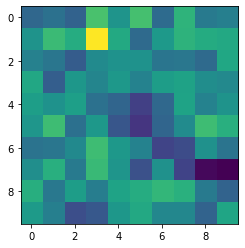

In [24]:
image_scores = np.genfromtxt('image_scores_FULL_patches.csv', delimiter=',')
plt.imshow(image_scores)

The above image is the heatmap of RMSE values for each patch. Dark patches are good patches for prediction with low RMSE scores. Bright patches are poor patches for prediction with high RMSE scores.

The above method takes very long to run (between 1-8 hours depending on how much data is included). A faster way to get an approximate representation is through mean pooling of patch segments. Pool together 4x4 squares to obtain the mean pixel value over that 4x4 pixel patch and only train on that mean value. This method is much faster.

Now we can rank the patches in terms of their scores. We are looking for patches that yield the lowest possible average errors. We are also interested in the variance of the patch scores to see if it is a patch that has high topographical variety. We will run more granular patch analysis on the 8x8 patches with high variance.

We now select the best patches as well as the patches with high variance for more granular patch analysis. Now we consider windows with width 5 pixels as opposed to windows with width 8 pixels.

In [25]:
# identify patches of interest in the image

# declare a dictionary that is used to store the mean RMSE of pixels in a patch and the
# variance of the RMSE of the pixels in the patch
patches_data = {}
pixel_analysis = False
patch_analysis = True
if pixel_analysis:
    # patch size (e.g., N = 5 will be a 5x5 patch for a total of 25 pixels)
    N = 1
    for i in range(0, 40, N):
        for j in range(0, 40, N):
            pixel_scores = []
            for pixel_a in range(i, i+N):
                for pixel_b in range(j, j+N):
                    pixel_scores.append(image_scores[pixel_a, pixel_b])
            # store data on the patch in a dictionary
            patches_data["({}, {})".format(i, j)] = (np.mean(pixel_scores), np.var(pixel_scores))

elif patch_analysis:
    # patch size (e.g., N = 5 will be a 5x5 patch for a total of 25 pixels)
    N = 4
    for i in range(0, 40//N):
        for j in range(0, 40//N):
            patches_data["({}, {})".format(i*N, j*N)] = image_scores[i,j]

We can take a look at the top patches from this pass as well. 

In [28]:
from operator import itemgetter
N  = 10
res = dict(sorted(patches_data.items(), key = itemgetter(1), reverse = False)[:N])
print(res)

{'(28, 36)': 1.4498671247031834, '(28, 32)': 1.453809207121367, '(20, 20)': 1.4787076635297773, '(16, 20)': 1.4852083841854524, '(28, 28)': 1.4871662662579, '(24, 24)': 1.4881977654041214, '(24, 28)': 1.4930616120505762, '(36, 8)': 1.4949801791965822, '(28, 20)': 1.4963831749302972, '(20, 16)': 1.5002009760459993}


Now we can select the best patch (or two best patches) and analyze the scores that each pixel yields. In the final model, multiple regressors will be trained on different subsets of the training set, each set focusing on a different pixel in the selected patch. The final model will yield a weighted average of these different regressors, where the weight is inversely proportional to the error of the pixel that the dataset yielded.

Now we can narrow down our search by starting with a wide window and downselecting. Once we have a few small windows, we can look at individual pixel scores within those windows. 

# Feature Dedicated Ensemble

Now that we have a way to get features from the inputs, we can fit the Feature Dedicated Ensemble model and see how it does:
**NOTE: to use test data, modify the folder name in the function sample_patch or sample_pixel to 'image_arrays_test'. If desire to use training data, use 'image_arrays_train'.**

Use formula for weight of each regressor:
  
$$ w_i = \frac{1}{2} log ( \frac{1 - err \textrm{ } patch_i}{err \textrm{ } patch_i}) + \frac{1}{2}log ( \frac{1 - err \textrm{ }HarvestGroup}{err\textrm{ }HarvestGroup}) $$ 

Below is the Feature Dedicated Ensemble for pixels.

In [44]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import time

class VotingRegressor:
    
    def __init__(self, RMSE_pixels, RMSE_months, pixels, harvest_months, nonharvest_months):
        # Now we must make the models
        models = []
        for i in range(len(RMSE_pixels)*len(RMSE_months)):
            model = RandomForestRegressor(n_estimators=100, max_depth=6)
            models.append(model)
        self.model = models
        self.pixels_of_interest = pixels
        self.harvest_months = harvest_months
        self.nonharvest_months = nonharvest_months
        self.RMSE_pixels = RMSE_pixels
        self.RMSE_months = RMSE_months
        self.weights = self.get_weights()
        
    def get_weights(self):
        # Now the model is trained. Now we must populate the weight matrix.
        w = []
        for i in range(len(self.RMSE_months)):
            w_month = 0.5 * np.log((1 - self.RMSE_months[i]) / self.RMSE_months[i])
            for j in range(len(self.RMSE_pixels)):
                w_pixel = 0.5 * np.log((1 - self.RMSE_pixels[j]) / self.RMSE_pixels[j])
                w.append(w_month + w_pixel)
        return w

    def train(self, data):
        print("Training the model")
        # Now we must create new datasets for the pixel/harvest month combinations. 
        # add the dataframes for the harvest months
        idxs = [x for x in range(data.shape[0])]
        df = []
        print("Making dataframes for training")
        for i in range(len(self.RMSE_pixels)):
            df_temp = make_df(data, self.pixels_of_interest[i][0], 
                              self.pixels_of_interest[i][1], idxs, month_range=self.harvest_months)
            df.append(df_temp)
        # add the dataframes for the nonharvest months
        for i in range(len(self.RMSE_pixels)):
            df_temp = make_df(data, self.pixels_of_interest[i][0], self.pixels_of_interest[i][1], 
                              idxs, month_range=self.nonharvest_months)
            df.append(df_temp)
        print("Training the model components")
        # Now df contains all the dataframes we need for our regressors. Now we can split the dataframes into 
        # training and testing sets and train the model.
        for i in range(len(self.RMSE_pixels)*len(self.RMSE_months)):
            X_train, y_train = split_xy(df[i])
            self.model[i].fit(X_train, y_train)

    def predict(self, test):
        print("Making prediction")
        df = []
        idxs = [x for x in range(test.shape[0])]
        print("Making the dataframes for prediction")
        for i in range(len(self.RMSE_pixels)):
            df_temp = make_df(test, self.pixels_of_interest[i][0], self.pixels_of_interest[i][1], 
                              idxs, month_range=self.harvest_months)
            df.append(df_temp)
        # add the dataframes for the nonharvest months
        for i in range(len(self.RMSE_pixels)):
            df_temp = make_df(test, self.pixels_of_interest[i][0], self.pixels_of_interest[i][1], 
                              idxs, month_range=self.nonharvest_months)
            df.append(df_temp)
        print("Making prediction with component dataframes")
        # now we can make a prediction with the model
        prediction = np.zeros(test.shape[0])
        for i in range(len(self.weights)):
            X_val,_ = split_xy(df[i]) 
            prediction += self.weights[i] * self.model[i].predict(X_val)
        prediction /= sum(self.weights)
        return prediction

In [46]:
# From a single large dataset, we must split the dataset up based on pixel and harvest month. 
# There are two month categories: harvest months and nonharvest months. They are as follows:
harvest_months = [4,5,6,7,8,9,10]
nonharvest_months = [1,2,3,11,12]
# the errors for these two months
RMSE_months = np.array([1.989, 1.704])
# normalize the RMSEs for the months
RMSE_months = RMSE_months/sum(RMSE_months)
# Then we must split the dataset based on the top 6 pixels of interest. They are:
pixels = [(18,11), (19,25), (32,27), (35,24), (20,20), (31,12)]
# the errors for each of these pixels
RMSE_pixels = np.array([1.562893669772938, 1.565668020752039, 1.5662930491128952, 
                        1.5669992616258848, 1.6219651889791495, 1.568149753069483])
# normalize the RMSEs for the pixels so as to use log formula
RMSE_pixels = RMSE_pixels/sum(RMSE_pixels)

# create the model
model = VotingRegressor(RMSE_pixels, RMSE_months, pixels, harvest_months, nonharvest_months)

# train the model with the training set
data_train, data_val, data_test = split_train(train)
model.train(data_train)

# now that we have prediction, we can test the accuracy of it by looking at the RMSE.
# get the test set
prediction = model.predict(data_val)

# get the error
_, y_val = split_xy(data_val)
error = mean_squared_error(y_val, prediction, squared=False)
print("RMSE Error with voting regressor: {}".format(error))

Training the model
Making dataframes for training


KeyboardInterrupt: 

Below is the Feature Dedicated Ensemble for patches.

In [42]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import time

class VotingRegressor_Patch:
    
    def __init__(self, RMSE_patches, RMSE_months, patches, harvest_months, nonharvest_months, N):
        # Now we must make the models
        models = []
        for i in range(len(RMSE_patches) * len(RMSE_months)):
            model = RandomForestRegressor(n_estimators=100, max_depth=6)
            models.append(model)
        self.model = models
        self.patch_width = N
        self.patches_of_interest = patches
        self.harvest_months = harvest_months
        self.nonharvest_months = nonharvest_months
        self.RMSE_patches = RMSE_patches
        self.RMSE_months = RMSE_months
        self.weights = self.get_weights()

    def get_weights(self):
        # Now the model is trained. Now we must populate the weight matrix.
        w = []
        for i in range(len(self.RMSE_months)):
            w_month = 0.5 * np.log((1 - self.RMSE_months[i]) / self.RMSE_months[i])
            for j in range(len(self.RMSE_patches)):
                w_patch = 0.5 * np.log((1 - self.RMSE_patches[j]) / self.RMSE_patches[j])
                w.append(w_month + w_patch)
        return w

    def train(self, data):
        print("Training the model")
        # Now we must create new datasets for the pixel/harvest month combinations. 
        # add the 5 dataframes for the harvest months
        idxs = [x for x in range(data.shape[0])]
        df = []
        print("Making dataframes for training")
        for i in range(len(self.RMSE_patches)):
            df_temp = make_df_patch(data, self.patches_of_interest[i][0], self.patches_of_interest[i][1], 
                                    self.patch_width, idxs, month_range=self.harvest_months)
            df.append(df_temp)
        # add the dataframes for the nonharvest months
        for i in range(len(self.RMSE_patches)):
            df_temp = make_df_patch(data, self.patches_of_interest[i][0], self.patches_of_interest[i][1], 
                                    self.patch_width, idxs, month_range=self.nonharvest_months)
            df.append(df_temp)
        print("Training the component models")
        # Now df contains all the dataframes we need for our regressors. Now we can split the dataframes into 
        # training and testing sets and train the model.
        for i in range(len(self.RMSE_patches) * len(self.RMSE_months)):
            X_train, y_train = split_xy(df[i])
            self.model[i].fit(X_train, y_train)

    def predict(self, test):
        print("Making prediction")
        df = []
        idxs = [x for x in range(test.shape[0])]
        print("Making the dataframes for prediction")
        for i in range(len(self.RMSE_patches)):
            df_temp = make_df_patch(test, self.patches_of_interest[i][0], self.patches_of_interest[i][1], 
                                    self.patch_width, idxs, month_range=self.harvest_months)
            df.append(df_temp)
        # add the dataframes for the nonharvest months
        for i in range(len(self.RMSE_patches)):
            df_temp = make_df_patch(test, self.patches_of_interest[i][0], self.patches_of_interest[i][1], 
                                    self.patch_width, idxs, month_range=self.nonharvest_months)
            df.append(df_temp)
        print("Making prediction with component dataframes")
        # now we can make a prediction with the model
        prediction = np.zeros(test.shape[0])
        for i in range(len(self.weights)):
            X_val,_ = split_xy(df[i]) 
            prediction += self.weights[i] * self.model[i].predict(X_val)
        prediction /= sum(self.weights)
        return prediction

In [43]:
# From a single large dataset, we must split the dataset up based on pixel and harvest month. 
# There are two month categories: harvest months and nonharvest months. They are as follows:
harvest_months = [7, 8, 9, 10, 11]
nonharvest_months = [0, 1, 2, 3, 4, 5, 6]
# the errors for these two months
RMSE_months = np.array([1.989, 1.704])
# normalize the RMSEs for the months
RMSE_months = RMSE_months/sum(RMSE_months)
# Then we must split the dataset based on the top 6 pixels of interest. They are:
patches = [(28, 36), (28, 32), (20, 20), (16, 20), (28, 28), (24, 24)]
# the errors for each of these pixels
RMSE_patches = np.array([1.4498671247031834, 1.453809207121367, 1.4787076635297773, 
                         1.4852083841854524, 1.4871662662579, 1.4881977654041214])
# normalize the RMSEs for the patches so as to use log formula
RMSE_patches = RMSE_patches/sum(RMSE_patches)
# create the model
model = VotingRegressor_Patch(RMSE_patches, RMSE_months, patches, harvest_months, nonharvest_months, 4)

# train the model with the training set
#data_train, data_val, data_test = split_train(train)
model.train(train)

# #now that we have prediction, we can test the accuracy of it by looking at the RMSE.
# # get the test set
# prediction = model.predict(data_val)

# # get the error
# _, y_val = split_xy(data_val)
# error = mean_squared_error(y_val, prediction, squared=False)
# print("RMSE Error with voting regressor: {}".format(error))

Training the model
Making dataframes for training
Training the component models


# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [469]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
#test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

# Get model predictions
preds = model.predict(ss)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

Making prediction
Making the dataframes for prediction
Making prediction with component dataframes


,Field_ID,Yield
0,E9UZCEA,3.082353
1,1WGGS1Q,3.047112
2,EG2KXE2,3.056978
3,HC3GQXF,3.045995
4,7AK6GFK,3.103559
